In [1]:
import healpy as hp 
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import numpy as np

In [13]:
%load_ext autoreload
%autoreload 2
from taunet.simulation import CMBmap, FGMap, SkySimulation,CMBspectra
from taunet.ncm import NoiseModel,NoiseModelGaussian

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
main_dir = '/marconi/home/userexternal/aidicher/storage/TAUNETG'
clean_dir = os.path.join(main_dir,'CLEAN')

In [4]:
nsim = 10
tau = 0.06
fg_model = ['s0','d0']

In [5]:
spectra = CMBspectra(tau=tau)

In [6]:
def get_cl(f,nsim,f1=None):
    cl = []
    for i in tqdm(range(nsim)):
        fname = os.path.join(clean_dir,f'cleaned_{f}_{i}.fits')
        Q,U = hp.read_map(fname,field=(1,2))
        _,E,_ = hp.map2alm([Q*0,Q,U])
        if f1 is not None:
            fname = os.path.join(clean_dir,f'cleaned_{f1}_{i}.fits')
            Q1,U1 = hp.read_map(fname,field=(1,2))
            _,E1,_ = hp.map2alm([Q1*0,Q1,U1])
            cl.append(hp.alm2cl(E,E1))
        else:
            cl.append(hp.alm2cl(E))
    return np.array(cl)


In [7]:
cl_100 = get_cl('100',nsim)

100%|██████████| 10/10 [00:46<00:00,  4.64s/it]


In [8]:
cl_143 = get_cl('143',nsim)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:46<00:00,  4.62s/it]


In [9]:
cl_100_143 = get_cl('100',nsim,'143')

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


In [10]:
l = np.arange(len(cl_100[0]))

In [11]:
ncm = NoiseModel()

In [12]:
nl_100,nl_143 = [],[]
for i in tqdm(range(nsim)):
    nl_100.append(hp.alm2cl(ncm.Emode(100)))
    nl_143.append(hp.alm2cl(ncm.Emode(143)))
nl_100 = np.array(nl_100).mean(axis=0)
nl_143 = np.array(nl_143).mean(axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


In [15]:
noise_levels = {
    '100': 55,
    '143': 60,
}
nl_100, nl_143 = [],[]
for i in tqdm(range(nsim)):
    nl_100.append(hp.alm2cl(NoiseModelGaussian(16,noise_levels['100']).Emode()))
    nl_143.append(hp.alm2cl(NoiseModelGaussian(16,noise_levels['143']).Emode()))
nl_100 = np.array(nl_100).mean(axis=0)
nl_143 = np.array(nl_143).mean(axis=0)

100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


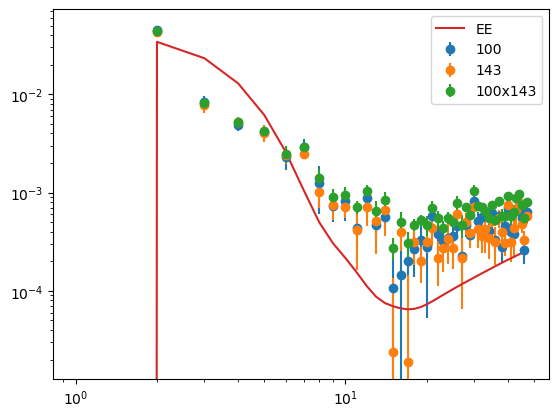

In [17]:
plt.errorbar(l,(cl_100.mean(axis=0)*1e12 - nl_100)/0.54,yerr=cl_100.std(axis=0)*1e12/0.54,fmt='o',label='100')
plt.errorbar(l,(cl_143.mean(axis=0)*1e12 - nl_143)/0.54,yerr=cl_143.std(axis=0)*1e12/0.54,fmt='o',label='143')
plt.errorbar(l,cl_100_143.mean(axis=0)*1e12/0.54,yerr=cl_100_143.std(axis=0)*1e12/0.54,fmt='o',label='100x143')
plt.loglog(l,spectra.EE[:48],label='EE')
plt.legend()